### Determine the best cfr/mbf models from log folders ###

In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

#print(plt.style.available)
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

#print(plt.style.available)
#plt.style.use('ggplot')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [2]:
# Directories and parameters
data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
pred_dir = os.path.join(data_root, 'predictions')

df_pred_files = sorted(glob.glob(os.path.join(pred_dir, '*_pred.parquet')))
df_cor_files = sorted(glob.glob(os.path.join(pred_dir, '*_cor.parquet')))

df_pred = pd.concat([pd.read_parquet(file) for file in df_pred_files]).reset_index(drop=True)
df_cor_0 = pd.concat([pd.read_parquet(file) for file in df_cor_files]).reset_index(drop=True)

In [3]:
df_gpu = pd.DataFrame({'model_name': sorted(list(df_cor_0.model_name.unique()))})
df_gpu[['dset', 'view', 'gpu', 'rest']] = df_gpu.model_name.str.split('_', n=3, expand=True)
df_gpu = df_gpu.drop(['dset', 'rest'], axis = 1)
# Join this with the main dataframe
df_cor = df_cor_0.merge(right=df_gpu, on='model_name', how='left')

In [4]:
print(f'We have {len(df_cor.model_name.unique())} models trained on {list(df_cor.gpu.unique())}')
print()
print(df_cor.model_name.unique())

We have 15 models trained on ['dgx-1', 'gpu2']

['cfr_a4c_dgx-1_fc1_global_cfr_calc' 'global_a4c_dgx-1_global_cfr_calc'
 'global_a4c_dgx-1_rest_global_mbf' 'global_a4c_dgx-1_stress_global_mbf'
 'global_a4c_gpu2_fc128_rest_global_mbf'
 'global_a4c_gpu2_fc128aug_rest_global_mbf'
 'global_a4c_gpu2_global_cfr_calc' 'global_a4c_gpu2_rest_global_mbf'
 'global_a4c_gpu2_stress_global_mbf' 'nondefect_a4c_dgx-1_rest_mbf_unaff'
 'nondefect_a4c_dgx-1_stress_mbf_unaff'
 'nondefect_a4c_dgx-1_unaffected_cfr'
 'nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff'
 'nondefect_a4c_gpu2_fc64aug_stress_mbf_unaff'
 'nondefect_a4c_gpu2_fc64aug_unaffected_cfr']


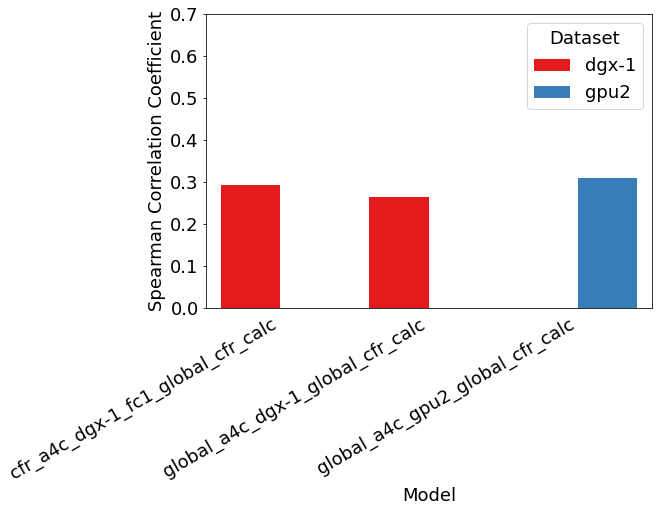

In [5]:
# Lets compare the machines
#df_cor_gpu = df_cor[(df_cor.epoch==150) & (df_cor.model_output=='rest_global_mbf')]
df_cor_gpu = df_cor[(df_cor.epoch==150) & (df_cor.model_output=='global_cfr_calc')]

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = 'model_name', y = 'spear_cor', data=df_cor_gpu, ax=ax,
            saturation = 1, hue='gpu', palette='Set1')
ax.set(ylim=[0, 0.7], yticks=np.arange(0, 0.8, 0.1))
ax.xaxis.set_ticks_position('none') 
ax.set(xlabel = 'Model', ylabel = 'Spearman Correlation Coefficient')

leg = plt.legend(title='Dataset')
leg._legend_box.align = 'center'

fig.autofmt_xdate()

# Save plot
fig.savefig(os.path.join(pred_dir, 'cfr_models_gpu.png'), dpi=300, bbox_inches='tight')

plt.show()

In [6]:
df_cor.head()

,model_name,model_output,epoch,checkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset,chechkpoint_file,view,gpu
0,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.234042,4.329830e-15,0.273507,3.068569e-20,1095,cfr,NaN,a4c,dgx-1
1,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,150,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.291996,5.776872e-23,0.319546,2.046985e-27,1095,cfr,NaN,a4c,dgx-1
2,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,200,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.266242,3.178142e-19,0.303751,8.336292e-25,1095,cfr,NaN,a4c,dgx-1
3,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,300,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.256280,6.988946e-18,0.306535,2.967788e-25,1095,cfr,NaN,a4c,dgx-1
4,global_a4c_dgx-1_global_cfr_calc,global_cfr_calc,50,NaN,0.236498,7.719762e-15,0.250083,1.828337e-16,1052,global,/mnt/obi0/andreas/data/cfr/log/global_a4c_dgx-...,a4c,dgx-1


In [7]:
df_cor.model_name.unique()

array(['cfr_a4c_dgx-1_fc1_global_cfr_calc',
       'global_a4c_dgx-1_global_cfr_calc',
       'global_a4c_dgx-1_rest_global_mbf',
       'global_a4c_dgx-1_stress_global_mbf',
       'global_a4c_gpu2_fc128_rest_global_mbf',
       'global_a4c_gpu2_fc128aug_rest_global_mbf',
       'global_a4c_gpu2_global_cfr_calc',
       'global_a4c_gpu2_rest_global_mbf',
       'global_a4c_gpu2_stress_global_mbf',
       'nondefect_a4c_dgx-1_rest_mbf_unaff',
       'nondefect_a4c_dgx-1_stress_mbf_unaff',
       'nondefect_a4c_dgx-1_unaffected_cfr',
       'nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff',
       'nondefect_a4c_gpu2_fc64aug_stress_mbf_unaff',
       'nondefect_a4c_gpu2_fc64aug_unaffected_cfr'], dtype=object)

In [8]:
df_cor[df_cor.model_name.isin(['nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff',
                               'nondefect_a4c_dgx-1_rest_mbf_unaff']) & (df_cor.epoch==100)]

,model_name,model_output,epoch,checkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset,chechkpoint_file,view,gpu
29,nondefect_a4c_dgx-1_rest_mbf_unaff,rest_mbf_unaff,100,NaN,0.343776,7.655502e-26,0.350960,6.191784e-27,881,nondefect,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_d...,a4c,dgx-1
38,nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff,rest_mbf_unaff,100,NaN,0.361337,1.457461e-28,0.349529,1.027315e-26,881,nondefect,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_g...,a4c,gpu2


In [9]:
df_cor_rest_mbf_unaff = df_cor[(df_cor.model_name=='nondefect_a4c_dgx-1_rest_mbf_unaff') & (df_cor.epoch==100)]
df_cor_rest_mbf_unaff

,model_name,model_output,epoch,checkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset,chechkpoint_file,view,gpu
29,nondefect_a4c_dgx-1_rest_mbf_unaff,rest_mbf_unaff,100,NaN,0.343776,7.655502e-26,0.35096,6.191784e-27,881,nondefect,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_d...,a4c,dgx-1


In [10]:
df_corx = df_cor.loc[df_cor.groupby('model_output')['spear_cor'].idxmax()].reset_index(drop=True)
df_corx = df_corx.sort_values(by = ['dset', 'spear_cor'], ascending=False)

# We want to replace row 2 with fc64aug because its a different architecture
df_corx = pd.concat([df_cor_rest_mbf_unaff, df_corx], axis=0, ignore_index=True)
df_corx = df_corx.drop(df_corx[df_corx.model_name=='nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff'].index).\
            reset_index(drop=True)
#df_corx = df_corx.loc[~df_corx.model_name=='nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff']

In [11]:
df_cor.head()

,model_name,model_output,epoch,checkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset,chechkpoint_file,view,gpu
0,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.234042,4.329830e-15,0.273507,3.068569e-20,1095,cfr,NaN,a4c,dgx-1
1,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,150,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.291996,5.776872e-23,0.319546,2.046985e-27,1095,cfr,NaN,a4c,dgx-1
2,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,200,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.266242,3.178142e-19,0.303751,8.336292e-25,1095,cfr,NaN,a4c,dgx-1
3,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,300,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.256280,6.988946e-18,0.306535,2.967788e-25,1095,cfr,NaN,a4c,dgx-1
4,global_a4c_dgx-1_global_cfr_calc,global_cfr_calc,50,NaN,0.236498,7.719762e-15,0.250083,1.828337e-16,1052,global,/mnt/obi0/andreas/data/cfr/log/global_a4c_dgx-...,a4c,dgx-1


In [12]:
df_cor[df_cor.model_name=='cfr_a4c_dgx-1_fc1_global_cfr_calc'][['model_name', 'epoch', 'spear_cor']]

,model_name,epoch,spear_cor
0,cfr_a4c_dgx-1_fc1_global_cfr_calc,100,0.234042
1,cfr_a4c_dgx-1_fc1_global_cfr_calc,150,0.291996
2,cfr_a4c_dgx-1_fc1_global_cfr_calc,200,0.266242
3,cfr_a4c_dgx-1_fc1_global_cfr_calc,300,0.256280


In [13]:
# Save all model results
models_filename = 'cfr_model_correlations_100625.parquet'
df_cor.to_parquet(os.path.join(data_root, models_filename))

# We want to replace the model nondefect_a4c_gpu2_fc64aug_rest_mbf_unaff by one with other architecture
#missing_model_filename = 'best_models_200607_replacement.parquet'
#df_cor_rest_mbf_unaff.to_parquet(os.path.join(pred_dir, missing_model_filename))

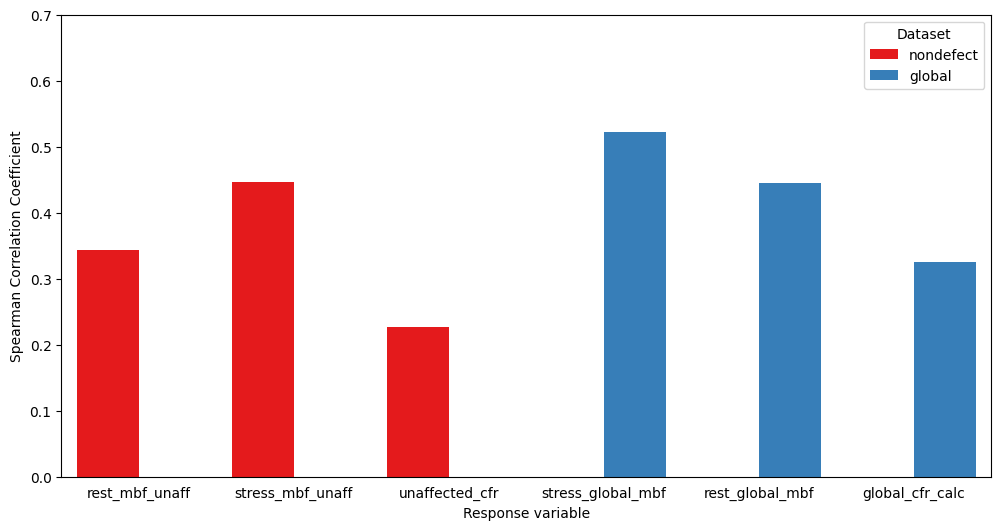

In [15]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x = 'model_output', y = 'spear_cor', data=df_corx, ax=ax,
            saturation = 1, hue='dset', palette='Set1')
ax.set(ylim=[0, 0.7], yticks=np.arange(0, 0.8, 0.1))
ax.xaxis.set_ticks_position('none') 
ax.set(xlabel = 'Response variable', ylabel = 'Spearman Correlation Coefficient')

leg = plt.legend(title='Dataset')
leg._legend_box.align = 'center'

plt.show()

# Save plot
fig.savefig(os.path.join(pred_dir, 'correlations.png'), dpi=300, bbox_inches='tight')

In [16]:
def ax_style(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, alpha=0.75, zorder=0, color='#505050', linestyle='--', dashes = [2,2])
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #ax.set_xlim([-0.02, 1.0])
    #ax.set_ylim([-0.02, 1.05])
    ax.set_facecolor('#f7f7f7')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
    #ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    #ax.legend(loc='best', frameon=False)
    
    return ax

# Lets do a scatter plot with Rahul's style
def scatter_plot(X, Y, cor, lim=[0, 5], xl='Predicted', yl='Observed'):
    
    fontsize=18
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(X, Y, color='#732673', alpha = 0.7, s=5)
    ax.set(xlabel=xl, ylabel=yl)
    
    #hlim = [0, 5]
    hticks = np.arange(lim[0], lim[1]+0.2, 1)
    
    ax.set(xlim=lim, xticks=hticks,  
           ylim=lim, yticks=hticks)
    
    ax = ax_style(ax)
    
    ax.text(x=0.95, y=0.01, s=r'$\rho$='+str(cor), verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='k', fontsize=fontsize)
    
    plt.minorticks_on()
    plt.tight_layout()
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
    
    return fig, ax

In [34]:
df_pred.head()

,label,pred,model_name,model_output,epoch,checkpoint_file,dset
0,1.352094,1.674593,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,cfr
1,0.790368,1.546885,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,cfr
2,1.304428,1.209312,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,cfr
3,2.013196,1.387584,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,cfr
4,0.840731,1.794161,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,100,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,cfr


In [36]:
model_name = 'cfr_a4c_dgx-1_fc1_global_cfr_calc'
model_epoch = 150
model_df = df_cor[(df_cor.model_name==model_name) & (df_cor.epoch==model_epoch)]
model_cor = np.around(model_df.spear_cor.values[0], decimals=2)
test_preds = df_pred[(df_pred.model_name==model_name) & (df_pred.epoch==model_epoch)]
model_df

,model_name,model_output,epoch,checkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset,chechkpoint_file,view,gpu
1,cfr_a4c_dgx-1_fc1_global_cfr_calc,global_cfr_calc,150,/mnt/obi0/andreas/data/cfr/log/cfr_a4c_dgx-1_f...,0.291996,5.776872e-23,0.319546,2.046985e-27,1095,cfr,NaN,a4c,dgx-1


0.29


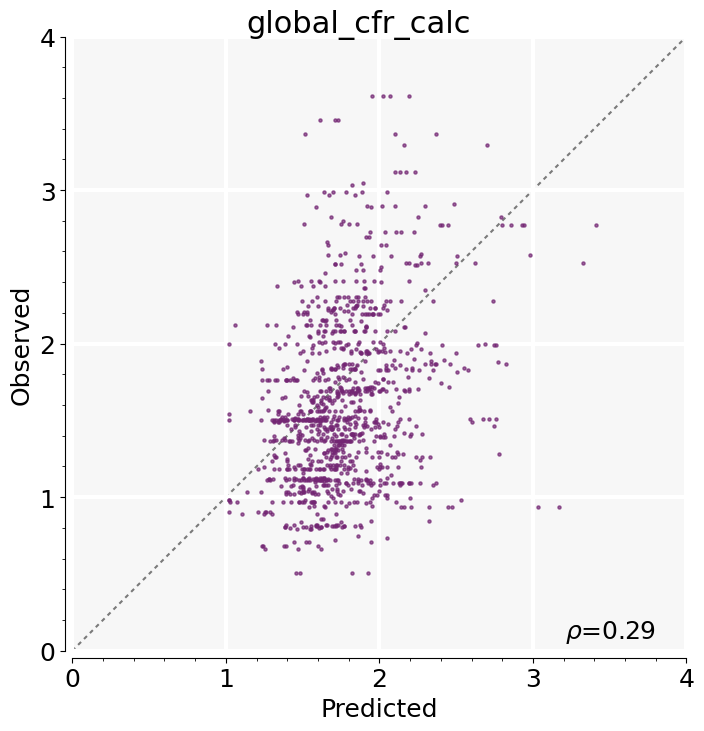

In [40]:
X = test_preds.pred
Y = test_preds.label
cor = spearmanr(X, Y)
print(np.around(cor[0], decimals=2))

#for model in df_corx.model_name.unique():
fig, ax = scatter_plot(X, Y, lim=[0, 4], cor=model_cor, xl='Predicted', yl='Observed')
fig.suptitle(model_df.model_output.values[0], fontsize=22, verticalalignment='top', y=1.01)
plt.show()
# Save plot
filename = model_name+'_scatter.png'
fig.savefig(os.path.join(pred_dir, 'images', filename), dpi=300, bbox_inches='tight')

In [39]:
filename

NameError: name 'filename' is not defined

In [ ]:
df_stress_global_mbf = df_pred[(df_pred.model_name=='global_a4c_gpu2_stress_global_mbf') & (df_pred.epoch==150)]
df_stress_global_mbf.head()


In [ ]:
fig, ax = scatter_plot(X, Y, xlabel='True', ylabel='Predicted')
fig.suptitle('global_a4c_gpu2_stress_global_mbf', fontsize=14)
plt.show()

fig.savefig(os.path.join(pred_dir, 'global_a4c_gpu2_stress_global_mbf.png'), dpi=300, bbox_inches='tight')
plt.close(fig)